# AutoGluon Time Series - Forecasting Quick Start

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/autogluon/autogluon/blob/master/docs/tutorials/timeseries/forecasting-quick-start.ipynb)
[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/autogluon/autogluon/blob/master/docs/tutorials/timeseries/forecasting-quick-start.ipynb)


Via a simple `fit()` call, AutoGluon can train and tune

- simple forecasting models (e.g., ARIMA, ETS, Theta),
- powerful deep learning models (e.g., DeepAR, Temporal Fusion Transformer),
- tree-based models (e.g., LightGBM),
- an ensemble that combines predictions of other models

to produce multi-step ahead _probabilistic_ forecasts for univariate time series data.

This tutorial demonstrates how to quickly start using AutoGluon to generate hourly forecasts for the [M4 forecasting competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128) dataset.

## Loading time series data as a `TimeSeriesDataFrame`

First, we import some required modules

In [1]:
!pip install autogluon.timeseries
!pip uninstall torchaudio torchvision torchtext -y  # fix incompatible package versions on Colab


Found existing installation: torchvision 0.15.2
Uninstalling torchvision-0.15.2:
  Successfully uninstalled torchvision-0.15.2


In [1]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor


To use `autogluon.timeseries`, we will only need the following two classes:

- `TimeSeriesDataFrame` stores a dataset consisting of multiple time series.
- `TimeSeriesPredictor` takes care of fitting, tuning and selecting the best forecasting models, as well as generating new forecasts.

We load a subset of the M4 hourly dataset as a `pandas.DataFrame`

In [2]:
df = pd.read_csv("https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_subset/train.csv")
df.head()


,item_id,timestamp,target
0,H1,1750-01-01 00:00:00,605.0
1,H1,1750-01-01 01:00:00,586.0
2,H1,1750-01-01 02:00:00,586.0
3,H1,1750-01-01 03:00:00,559.0
4,H1,1750-01-01 04:00:00,511.0


AutoGluon expects time series data in [long format](https://doc.dataiku.com/dss/latest/time-series/data-formatting.html#long-format).
Each row of the data frame contains a single observation (timestep) of a single time series represented by

- unique ID of the time series (`"item_id"`) as int or str
- timestamp of the observation (`"timestamp"`) as a `pandas.Timestamp` or compatible format
- numeric value of the time series (`"target"`)

The raw dataset should always follow this format with at least three columns for unique ID, timestamp, and target value, but the names of these columns can be arbitrary.
It is important, however, that we provide the names of the columns when constructing a `TimeSeriesDataFrame` that is used by AutoGluon.
AutoGluon will raise an exception if the data doesn't match the expected format.

In [3]:
train_data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="item_id",
    timestamp_column="timestamp"
)
train_data.head()


target
item_id timestamp                  
H1      1750-01-01 00:00:00   605.0
        1750-01-01 01:00:00   586.0
        1750-01-01 02:00:00   586.0
        1750-01-01 03:00:00   559.0
        1750-01-01 04:00:00   511.0

We refer to each individual time series stored in a `TimeSeriesDataFrame` as an _item_.
For example, items might correspond to different products in demand forecasting, or to different stocks in financial datasets.
This setting is also referred to as a _panel_ of time series.
Note that this is *not* the same as multivariate forecasting — AutoGluon generates forecasts for each time series individually, without modeling interactions between different items (time series).

`TimeSeriesDataFrame` inherits from [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html), so all attributes and methods of `pandas.DataFrame` are available in a `TimeSeriesDataFrame`.
It also provides other utility functions, such as loaders for different data formats (see [TimeSeriesDataFrame](../../api/autogluon.timeseries.TimeSeriesDataFrame) for details).

## Training time series models with `TimeSeriesPredictor.fit`
To forecast future values of the time series, we need to create a `TimeSeriesPredictor` object.

Models in `autogluon.timeseries` forecast time series _multiple steps_ into the future.
We choose the number of these steps — the _prediction length_ (also known as the _forecast horizon_) —  depending on our task.
For example, our dataset contains time series measured at hourly _frequency_, so we set `prediction_length = 48` to train models that forecast up to 48 hours into the future.

We instruct AutoGluon to save trained models in the folder `./autogluon-m4-hourly`.
We also specify that AutoGluon should rank models according to [mean absolute scaled error (MASE)](https://en.wikipedia.org/wiki/Mean_absolute_scaled_error), and that data that we want to forecast is stored in the column `"target"` of the `TimeSeriesDataFrame`.

In [4]:
predictor = TimeSeriesPredictor(
    prediction_length=48,
    path="autogluon-m4-hourly",
    target="target",
    eval_metric="MASE",
)

predictor.fit(
    train_data,
    presets="medium_quality",
    time_limit=600,
)


Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'autogluon-m4-hourly'
=================== System Info ===================
AutoGluon Version:  1.0.1b20240126
Python Version:     3.10.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Jan 16 18:42:40 UTC 2024
CPU Count:          32
GPU Count:          4
Memory Avail:       224.27 GB / 239.85 GB (93.5%)
Disk Space Avail:   317.97 GB / 984.21 GB (32.3%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': 'light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 48,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': 'target',
 'time_limit': 600,
 'verbosity': 2}

Inferred time series frequency: 'H'
Provided train_data has 148060 rows, 200 time series. Median time series lengt

Here we used the `"medium_quality"` presets and limited the training time to 10 minutes (600 seconds).
The presets define which models AutoGluon will try to fit.
For `medium_quality` presets, these are
simple baselines (`Naive`, `SeasonalNaive`),
statistical models (`ETS`, `Theta`),
tree-based models based on LightGBM (`RecursiveTabular`, `DirectTabular`),
a deep learning model `TemporalFusionTransformer`,
and a weighted ensemble combining these.
Other available presets for `TimeSeriesPredictor` are `"fast_training"`, `"high_quality"` and `"best_quality"`.
Higher quality presets will usually produce more accurate forecasts but take longer to train.

Inside `fit()`, AutoGluon will train as many models as possible within the given time limit.
Trained models are then ranked based on their performance on an internal validation set.
By default, this validation set is constructed by holding out the last `prediction_length` timesteps of each time series in `train_data`.


## Generating forecasts with `TimeSeriesPredictor.predict`

We can now use the fitted `TimeSeriesPredictor` to forecast the future time series values.
By default, AutoGluon will make forecasts using the model that had the best score on the internal validation set.
The forecast always includes predictions for the next `prediction_length` timesteps, starting from the end of each time series in `train_data`.

In [5]:
predictions = predictor.predict(train_data)
predictions.head()


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean         0.1         0.2         0.3  \
item_id timestamp                                                             
H1      1750-01-30 04:00:00  628.266367  608.160742  615.062590  620.039308   
        1750-01-30 05:00:00  558.064668  531.817389  540.827541  547.324495   
        1750-01-30 06:00:00  515.703113  484.740065  495.369043  503.033285   
        1750-01-30 07:00:00  484.100765  449.160071  461.154494  469.803316   
        1750-01-30 08:00:00  460.626424  422.179810  435.377743  444.894381   

                                    0.4         0.5         0.6         0.7  \
item_id timestamp                                                             
H1      1750-01-30 04:00:00  624.291730  628.266367  632.241003  636.493425   
        1750-01-30 05:00:00  552.875902  558.064668  563.253435  568.804842   
        1750-01-30 06:00:00  509.582096  515.703113  521.824130  528.372942   
        1750-01-30 07:00:00  477.193416  484.100765  491.008113  498.398213   
        1750-01-30 08:00:00  453.025997  460.626424  468.226850  476.358466   

                                    0.8         0.9  
item_id timestamp                                    
H1      1750-01-30 04:00:00  641.470143  648.371991  
        1750-01-30 05:00:00  575.301796  584.311947  
        1750-01-30 06:00:00  536.037183  546.666162  
        1750-01-30 07:00:00  507.047036  519.041458  
        1750-01-30 08:00:00  485.875104  499.073037

AutoGluon produces a _probabilistic_ forecast: in addition to predicting the mean (expected value) of the time series in the future, models also provide the quantiles of the forecast distribution.
The quantile forecasts give us an idea about the range of possible outcomes.
For example, if the `"0.1"` quantile is equal to `500.0`, it means that the model predicts a 10% chance that the target value will be below `500.0`.

We will now visualize the forecast and the actually observed values for one of the time series in the dataset.
We plot the mean forecast, as well as the 10% and 90% quantiles to show the range of potential outcomes.

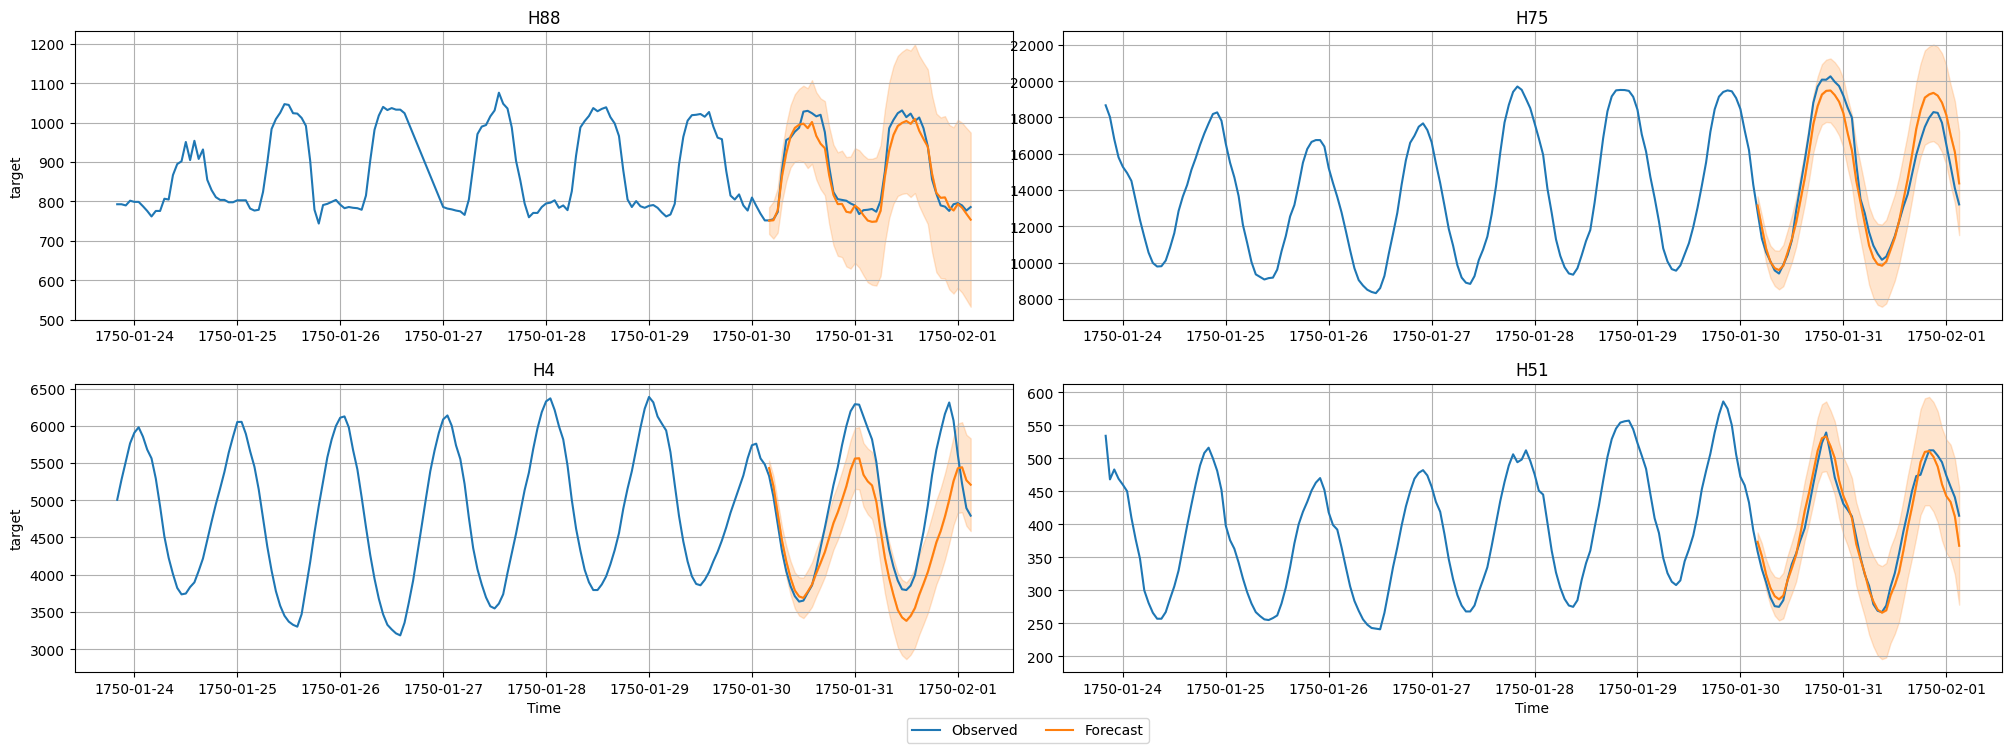

In [8]:
import matplotlib.pyplot as plt

# TimeSeriesDataFrame can also be loaded directly from a file
test_data = TimeSeriesDataFrame.from_path("https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_subset/test.csv")

# Plot 4 randomly chosen time series and the respective forecasts
predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=200, max_num_item_ids=4)


## Evaluating the performance of different models

We can view the performance of each model AutoGluon has trained via the `leaderboard()` method.
We provide the test data set to the leaderboard function to see how well our fitted models are doing on the unseen test data.
The leaderboard also includes the validation scores computed on the internal validation dataset.

In AutoGluon leaderboards, higher scores always correspond to better predictive performance.
Therefore our MASE scores are multiplied by `-1`, such that higher "negative MASE"s correspond to more accurate forecasts.

In [7]:
# The test score is computed using the last
# prediction_length=48 timesteps of each time series in test_data
predictor.leaderboard(test_data)


Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-0.855041,-0.914341,55.471105,51.426491,4.032811,8
1,RecursiveTabular,-0.862797,-0.933874,1.407214,2.317271,8.866268,5
2,SeasonalNaive,-1.022854,-1.216909,3.769584,0.245828,0.107493,2
3,DirectTabular,-1.683834,-1.370318,0.459086,0.410623,4.789708,6
4,ETS,-1.805637,-1.968375,49.824694,48.452769,0.107364,3
5,Theta,-1.905365,-2.142531,19.591044,20.868057,0.104226,4
6,TemporalFusionTransformer,-2.083086,-2.577880,0.447708,0.347935,108.772373,7
7,Naive,-6.696079,-6.662942,0.253405,2.107836,0.114559,1


## Summary
We used `autogluon.timeseries` to make probabilistic multi-step forecasts on the M4 Hourly dataset.
Check out [Forecasting Time Series - In Depth](forecasting-indepth.ipynb) to learn about the advanced capabilities of AutoGluon for time series forecasting.